In [1]:
from inspect import isfunction
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from datasets import load_dataset
from pathlib import Path
import numpy as np
from torch.optim import Adam
from unet import Unet


In [2]:
data = np.load("data.npy")

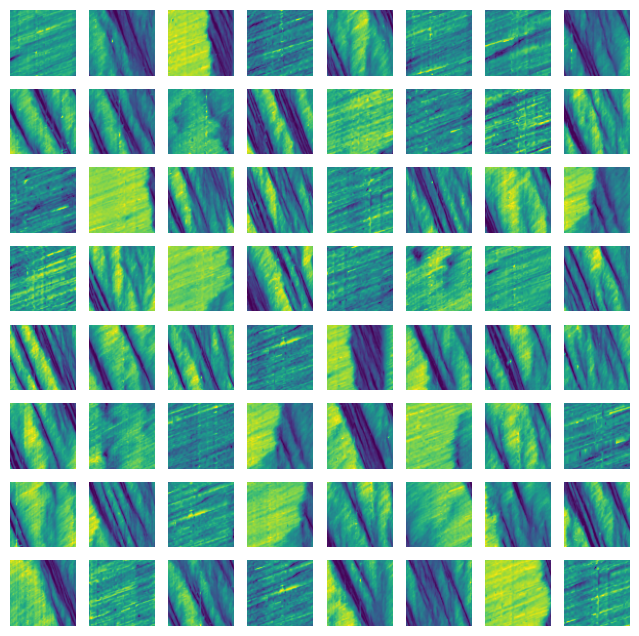

In [3]:
fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(data[np.random.randint(data.shape[0])][0], origin="lower" )
        ax[i, j].axis("off")

In [4]:
# Normalize the data with min-max scaling

data_min = 0 # data.min()
data_max = data.max()

data = (data - data_min) / (data_max - data_min)

In [5]:
# Split the data into training and validation sets
train_size = int(0.8 * len(data))
val_size = len(data) - train_size

train_data, val_data = torch.utils.data.random_split(data, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

In [6]:
# Helper functions
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

def cosine_beta_schedule(timesteps, s=0.008):
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start ** 0.5, beta_end ** 0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start

def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def q_sample(x_start, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)
    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x_start.shape)
    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

def get_noisy_image(x_start, t, reverse_transform, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod):
    x_noisy = q_sample(x_start, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod)
    noisy_image = reverse_transform(x_noisy.squeeze())
    return noisy_image


def p_losses(denoise_model, x_start, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, noise=None, cond=None, loss_type="l1"):
    if noise is None:
        noise = torch.randn_like(x_start)
    x_noisy = q_sample(x_start, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, noise=noise)
    predicted_noise = denoise_model(x_noisy, t, cond)
    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()
    return loss

@torch.no_grad()
def p_sample(model, x, t, t_index, betas, sqrt_recip_alphas, sqrt_one_minus_alphas_cumprod, posterior_variance, cond):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)
    model_mean = sqrt_recip_alphas_t * (x - betas_t * model(x, t, cond) / sqrt_one_minus_alphas_cumprod_t)
    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def p_sample_loop(model, shape, betas, sqrt_recip_alphas, sqrt_one_minus_alphas_cumprod, posterior_variance, timesteps, cond=None):
    device = next(model.parameters()).device
    b = shape[0]
    img = torch.randn(shape, device=device)
    imgs = []
    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i, betas, sqrt_recip_alphas, sqrt_one_minus_alphas_cumprod, posterior_variance, cond)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad()
def sample(model, image_size, batch_size, channels, betas, sqrt_recip_alphas, sqrt_one_minus_alphas_cumprod, posterior_variance, timesteps, cond=None):
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size), betas=betas, sqrt_recip_alphas=sqrt_recip_alphas, sqrt_one_minus_alphas_cumprod=sqrt_one_minus_alphas_cumprod, posterior_variance=posterior_variance, timesteps=timesteps, cond=cond)

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

In [7]:
# deine variable and hyperparameter 
timesteps = 500
betas = linear_beta_schedule(timesteps=timesteps)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

image_size = 64
channels = 1
device = "cuda:0" if torch.cuda.is_available() else "cpu"
lr = 0.0005

model = Unet(dim=image_size, channels=channels, dim_mults=(1, 2, 4,))
model.to(device)

optimizer = Adam(model.parameters(), lr=lr)
num_epochs = 10


In [8]:
# Training Loop
for epoch in range(num_epochs):
    loss_list = [] 
    for step, batch in enumerate(train_loader):
        optimizer.zero_grad()

        batch_size = batch.shape[0]
        batch = batch[:,0:1,:,:].float().to(device)

        t = torch.randint(0, timesteps, (batch_size,), device=device).long()
        loss = p_losses(model, batch, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, loss_type="huber")
        loss_list.append(loss.item())
        loss.backward()
        optimizer.step()
    loss_list = np.mean(loss_list)
    
    print(f"Epoch {epoch+1}/{num_epochs} Loss: {loss_list}")

Epoch 1/10 Loss: 0.20211862912774087
Epoch 2/10 Loss: 0.026430221796035765
Epoch 3/10 Loss: 0.011431141313165426
Epoch 4/10 Loss: 0.00967569575458765
Epoch 5/10 Loss: 0.009619581568986178
Epoch 6/10 Loss: 0.008210686806589365
Epoch 7/10 Loss: 0.008326879464089871
Epoch 8/10 Loss: 0.007907679315656424
Epoch 9/10 Loss: 0.007942233027890325
Epoch 10/10 Loss: 0.008074928181245923


sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

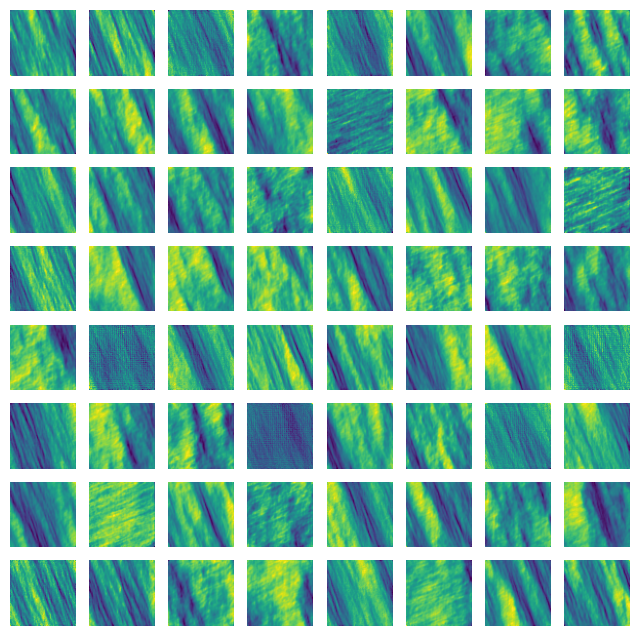

In [9]:
# Sample images
samples = sample(model, image_size=image_size, batch_size=64, channels=channels, betas=betas, sqrt_recip_alphas=sqrt_recip_alphas, sqrt_one_minus_alphas_cumprod=sqrt_one_minus_alphas_cumprod, posterior_variance=posterior_variance, timesteps=timesteps)
sample_list = samples[-1]

fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(sample_list[i * 8 + j][0,:,:], origin="lower")
        ax[i, j].axis("off")
plt.show()